In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1 — Imports, Config, and Data Loading

In [ ]:
# ================================
# STEP 1: Imports, Config, Loading
# ================================
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Pretty printing
pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (8,5)

# Folders
OUTPUT_DIR = "outputs"
DATA_DIR   = "csv_files"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Loading datasets...")

# Updated dataset paths
historical_data_path = os.path.join(DATA_DIR, "historical_data.csv")
sentiment_data_path  = os.path.join(DATA_DIR, "fear_greed_index.csv")

# Read files
df_trader    = pd.read_csv(historical_data_path)
df_sentiment = pd.read_csv(sentiment_data_path)

print("Loaded:")
print(f"- Trader rows: {len(df_trader):,}")
print(f"- Sentiment rows: {len(df_sentiment):,}")

print("\nHead — Trader:")
display(df_trader.head())
print("\nHead — Sentiment:")
display(df_sentiment.head())


In [ ]:
# ================================
# STEP 1: Imports, Config, Loading
# ================================
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Pretty printing
pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (8,5)

# ------------------------------this is for loading datasets from drive ------------->
# # Output folder (plots, CSVs)
# OUTPUT_DIR = "outputs"
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# print("Loading datasets...")

# # Update these paths
# historical_data_path = '/content/drive/My Drive/historical_data.csv'
# sentiment_data_path  = '/content/drive/My Drive/fear_greed_index.csv'

# --------------------------loading datasets from csv file , in case you are testing this code after cloning repo. --->
OUTPUT_DIR = "outputs"
DATA_DIR   = "csv_files"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Loading datasets...")

# Updated dataset paths
historical_data_path = os.path.join(DATA_DIR, "historical_data.csv")
sentiment_data_path  = os.path.join(DATA_DIR, "fear_greed_index.csv")

# Read files
df_trader    = pd.read_csv(historical_data_path)
df_sentiment = pd.read_csv(sentiment_data_path)

print("Loaded:")
print(f"- Trader rows: {len(df_trader):,}")
print(f"- Sentiment rows: {len(df_sentiment):,}")

print("\nHead — Trader:")
display(df_trader.head())
print("\nHead — Sentiment:")
display(df_sentiment.head())

Loading datasets...
Loaded:
- Trader rows: 211,224
- Sentiment rows: 2,644

Head — Trader:


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



Head — Sentiment:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


## Step 2 — Standardize Columns & Clean Basics

In [44]:
# --- Corrected Step 2: Data Preprocessing & Merging ---

# Trader dataset: convert 'Timestamp IST' to datetime and then extract date
# The format is 'DD-MM-YYYY HH:MM'
df_trader['date'] = pd.to_datetime(df_trader['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce').dt.date

# Sentiment dataset: convert 'date' to datetime
# The format is 'YYYY-MM-DD'
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], errors='coerce').dt.date

# Correcting the sentiment column name for clarity
# The original column is 'classification' not 'Sentiment'
df_sentiment.rename(columns={'classification': 'Sentiment'}, inplace=True)

# Ensure both 'date' columns are datetime objects before merging
df_trader['date'] = pd.to_datetime(df_trader['date'])
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])

# Merge datasets based on date
# The sentiment data provides daily classification, so we can merge the full trader dataset on date
df_merged = pd.merge(df_trader,
                     df_sentiment[['date', 'Sentiment']],
                     on='date',
                     how='left')

print("\n Merged Data (first 5 rows with corrected date conversion):")
print(df_merged.head())

print("\n Merged Data columns:")
print(df_merged.columns.tolist())

# --- Additional Check: Verify Date Overlap ---
# It's crucial to check if your dates overlap. An 'inner' merge would drop non-matching rows.
# 'left' merge keeps all trader data and adds sentiment where dates match.

trader_dates = df_trader['date'].dt.date.unique()
sentiment_dates = df_sentiment['date'].dt.date.unique()
overlap_dates = set(trader_dates).intersection(set(sentiment_dates))

print(f"\nNumber of unique dates in Trader data: {len(trader_dates)}")
print(f"Number of unique dates in Sentiment data: {len(sentiment_dates)}")
print(f"Number of overlapping dates: {len(overlap_dates)}")

if not overlap_dates:
    print("\nWarning: No overlapping dates found. The merge will result in an empty or nearly empty dataset. Please check the date formats and ranges in your raw data.")


 Merged Data (first 5 rows with corrected date conversion):
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                              

## Feature Engineering

In [45]:
# --- Step 3: Feature Engineering ---

# Standardize column names: lowercase and replace spaces with underscores
df_merged.columns = df_merged.columns.str.lower().str.replace(' ', '_')
df_merged.columns = df_merged.columns.str.lower().str.replace('.', '_', regex=False)
df_merged.columns = df_merged.columns.str.lower().str.replace('-', '_', regex=False)

print("\n Cleaned column names:")
print(df_merged.columns.tolist())

# Profitability flag (1 = profitable, 0 = loss)
df_merged['profitable'] = df_merged['closed_pnl'] > 0

# Risk proxy: size_usd / execution_price
df_merged['risk'] = df_merged['size_usd'] / df_merged['execution_price']

# Ensure numeric columns are numeric
numeric_cols = ['closed_pnl', 'size_usd', 'risk']
for col in numeric_cols:
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

# --- 4. Advanced Feature Engineering ---

# 1. Convert timestamp to datetime
# The correct timestamp column is 'timestamp_ist' from the trader data
df_merged['timestamp_ist'] = pd.to_datetime(df_merged['timestamp_ist'], format='%d-%m-%Y %H:%M')

# 2. Time-based features
df_merged['hour'] = df_merged['timestamp_ist'].dt.hour
df_merged['day_of_week'] = df_merged['timestamp_ist'].dt.dayofweek
df_merged['is_weekend'] = (df_merged['day_of_week'] >= 5).astype(int)

# 3. Trade-related features
df_merged['log_execution_price'] = np.log1p(df_merged['execution_price'])
df_merged['log_size_usd'] = np.log1p(df_merged['size_usd'])
df_merged['pnl_ratio'] = df_merged['closed_pnl'] / (df_merged['size_usd'] + 1e-9)

# 4. Cumulative metrics per account
# Ensure 'account' is a string type to avoid errors
df_merged['account'] = df_merged['account'].astype(str)

# Sort by date for proper cumulative calculation
df_merged = df_merged.sort_values(by='timestamp_ist')
df_merged['cumulative_pnl'] = df_merged.groupby('account')['closed_pnl'].cumsum()
df_merged['cumulative_trades'] = df_merged.groupby('account').cumcount() + 1
df_merged['avg_trade_size'] = (
    df_merged.groupby('account')['size_usd']
    .expanding()
    .mean()
    .reset_index(level=0, drop=True)
)

# 5. Sentiment-related features
# Encode sentiment (Fear/Greed to numeric)
sentiment_map = {
    'Extreme Fear': 1, 'Fear': 2, 'Neutral': 3,
    'Greed': 4, 'Extreme Greed': 5
}
df_merged['sentiment_encoded'] = df_merged['sentiment'].map(sentiment_map)

# Interaction features
df_merged['sentiment_x_size'] = df_merged['sentiment_encoded'] * df_merged['size_usd']
df_merged['sentiment_x_pnl'] = df_merged['sentiment_encoded'] * df_merged['closed_pnl']

# 6. Drop rows with NaN from rolling/shift operations
df_merged = df_merged.dropna().reset_index(drop=True)

print(" Feature engineering complete!")
print("New dataset shape:", df_merged.shape)
print("Columns now:", df_merged.columns.tolist())


 Cleaned column names:
['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'date', 'sentiment']
 Feature engineering complete!
New dataset shape: (211218, 32)
Columns now: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'date', 'sentiment', 'profitable', 'risk', 'hour', 'day_of_week', 'is_weekend', 'log_execution_price', 'log_size_usd', 'pnl_ratio', 'cumulative_pnl', 'cumulative_trades', 'avg_trade_size', 'sentiment_encoded', 'sentiment_x_size', 'sentiment_x_pnl']


## Exploratory Data Analysis

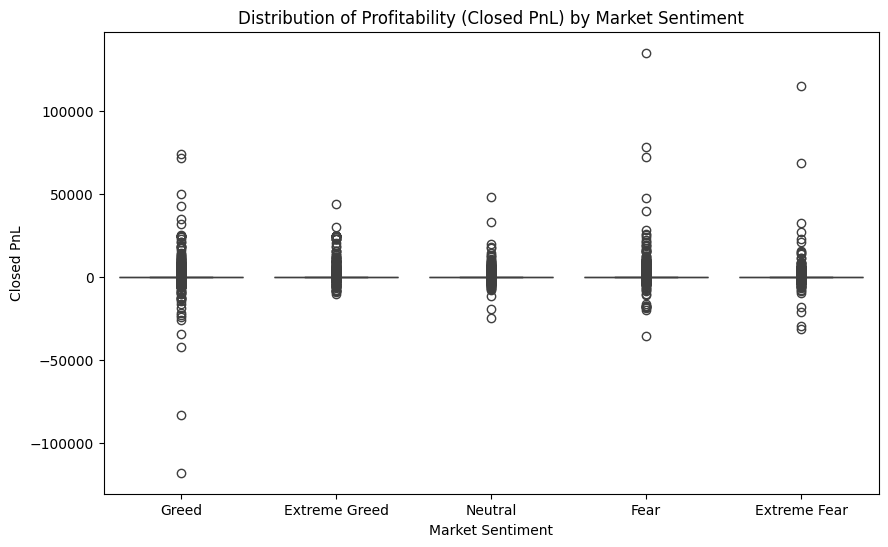

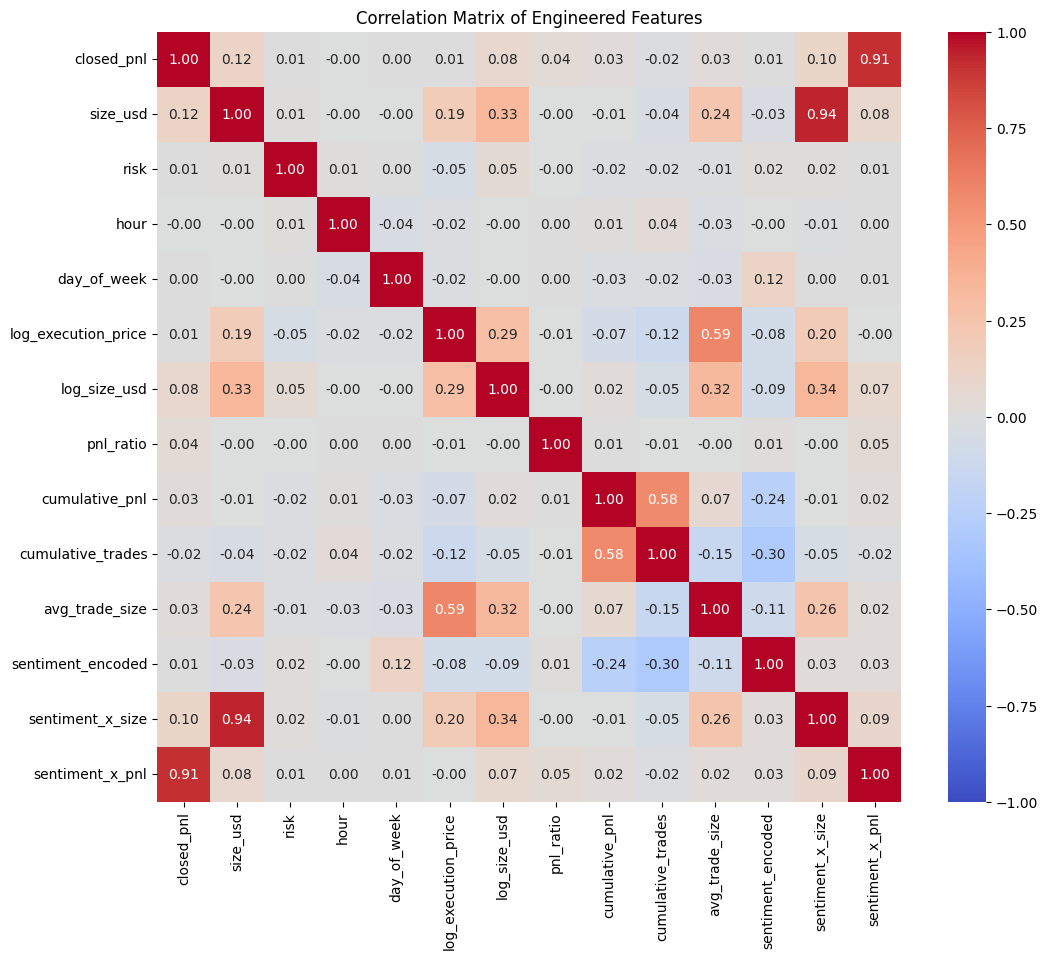

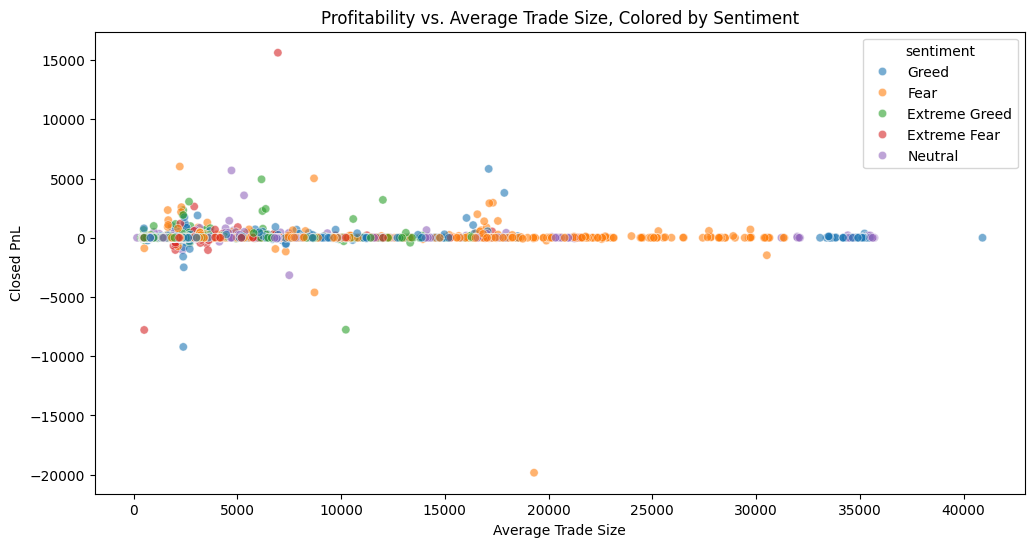

In [46]:
# --- Step 4: Exploratory Data Analysis (EDA) ---

# 4.1: Distribution of Profitability by Sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='closed_pnl', data=df_merged)
plt.title('Distribution of Profitability (Closed PnL) by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Closed PnL')
plt.show()

# 4.2: Correlation Heatmap of Key Features
# Select a subset of numeric columns for the heatmap
numeric_features = [
    'closed_pnl', 'size_usd', 'risk', 'hour', 'day_of_week',
    'log_execution_price', 'log_size_usd', 'pnl_ratio',
    'cumulative_pnl', 'cumulative_trades', 'avg_trade_size',
    'sentiment_encoded', 'sentiment_x_size', 'sentiment_x_pnl'
]
correlation_matrix = df_merged[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Engineered Features')
plt.show()

# 4.3: Plot the relationship between a key feature and profitability
plt.figure(figsize=(12, 6))
# Sample a smaller number of data points for faster plotting
sample_df = df_merged.sample(n=5000, random_state=42)
sns.scatterplot(
    x='avg_trade_size',
    y='closed_pnl',
    hue='sentiment',
    data=sample_df,
    alpha=0.6
)
plt.title('Profitability vs. Average Trade Size, Colored by Sentiment')
plt.xlabel('Average Trade Size')
plt.ylabel('Closed PnL')
plt.show()

## Step 5 : Predictive Modelling

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(




Model Performance Report:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     24871
        True       1.00      0.99      0.99     17373

    accuracy                           0.99     42244
   macro avg       1.00      0.99      0.99     42244
weighted avg       0.99      0.99      0.99     42244

ROC-AUC Score: 0.9995


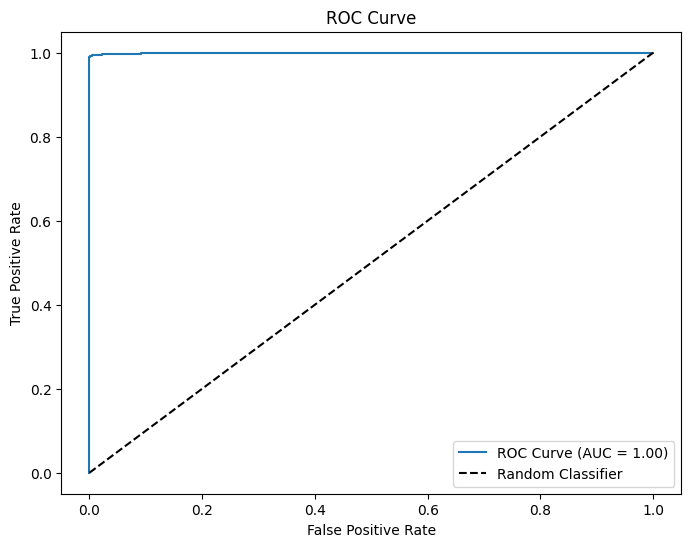


Analysis complete.


In [49]:
# --- 5.1: Define Features (X) and Target (y) ---
# Select the features you want to use to predict profitability.
features = [
    'size_usd', 'risk', 'hour', 'day_of_week', 'is_weekend',
    'log_execution_price', 'log_size_usd', 'pnl_ratio',
    'cumulative_pnl', 'cumulative_trades', 'avg_trade_size',
    'sentiment_encoded', 'sentiment_x_size', 'sentiment_x_pnl'
]

# The target variable is 'profitable'
X = df_merged[features].fillna(0) # Fill any remaining NaNs with 0
y = df_merged['profitable']

# --- 5.2: Handle Categorical Features (Corrected) ---
# One-hot encode the 'side' and 'direction' columns
categorical_features = ['side', 'direction']
df_merged_encoded = pd.get_dummies(df_merged, columns=categorical_features, drop_first=True)

# Update the features list to include the new one-hot encoded columns
encoded_features = features + [
    'side_SELL', # The new column for a 'SELL' trade
    'direction_Sell' # The new column for a 'Sell' direction
]

X_encoded = df_merged_encoded[encoded_features].fillna(0)
y_encoded = df_merged_encoded['profitable']

# --- 5.3: Split the Data and Train the Model ---
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# --- 5.4: Evaluate the Model ---
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print a classification report to see performance metrics
print("\n\nModel Performance Report:")
print(classification_report(y_test, y_pred))

# Calculate and print the Area Under the Receiver Operating Characteristic Curve (ROC-AUC)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# --- 5.5: Visualize the ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("\nAnalysis complete.")